# Data Quality Assessment für die Bachelorarbeit: Schadenserkennung bei Büchern mit machine learning

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import shutil
import copy

In [2]:
# einlesen der Daten von json
data = pd.read_json("../../../old/BAA/Annotierte_Bilder/2024-02-21-Schadenserkennung-Annotationen.json")
data = data.set_index("id")

## Verwerfen von nicht brauchbaren Daten

In [3]:
# verwerfen von nicht zu verwendenen Daten
#
#   created_at und updated_at geben keine informationen über den inhalt des bildes bzw der annotation
#   lead_time interessiert nicht
#   annotator_id ist die id + 54
#   annotator ist immer 1
#   choice hat 974/1081 nullwerte (Nan)
#   
# Die restlichen Werte können relevant sein für das trainieren des algorithmus

data_dropped = data.drop(["created_at", "updated_at", "lead_time", "annotation_id", "annotator", "choice"], axis=1)

## Kategorie "label" weiter aufteilen
Extrahieren der einzelnen Schadensarten und festlegen ob es überhaupt schäden hat.

In [4]:
label = pd.json_normalize(data_dropped["label"])
total = ['Schimmel', 'Wasser', 'Sonstiges', 'Schäden', 'Schmutz', 'Schädlinge']

# Add column for every category used
for x in total:
    data_dropped[x] = False
data_dropped["hat_schäden"] = None

# True where category is true
# rows
for x in range(label.shape[0]):
    rowx = set()
    # colums
    for y in range(label.shape[1]):
        if label[y][x] != None:
            rowx.add(label[y][x]["polygonlabels"][0])
    if label[0][x] == None:
        data_dropped.loc[x+1, "hat_schäden"]= False
    else:
        for s in rowx:
            data_dropped.loc[x+1, s] = True
        data_dropped.loc[x+1, "hat_schäden"] = True

## Datentyps kontrollieren
image ist ein objekt, da strings in pandas so gespeichert werden.

label ist ein objekt da es gemischte Datentypen enthält: strings, int, float, bool

In [5]:
# change "hat_schäden" da es nur True und Fale drin hat
data_preprocessed = data_dropped.astype({"hat_schäden" : "bool"})

In [6]:
data_preprocessed.dtypes

image          object
label          object
Schimmel         bool
Wasser           bool
Sonstiges        bool
Schäden          bool
Schmutz          bool
Schädlinge       bool
hat_schäden      bool
dtype: object

## Auf None/Nan kontrollieren
Wenn diese in "image" auftreten --> löschen

In [7]:
# False = keine None/Nan
nonetest = data_preprocessed["image"].isnull().any()

if nonetest == True:
    # drop rows with None only
    data_preprocessed.dropna(axis=0, how="all", inplace=True)
    # drop rows with none in image, without areference it is impossible to get to the right picture
    data_preprocessed.dropna(axis=0, subset=["image"], inplace=True)

## Mengen und verschiedene Anhaltspunkte

In [8]:
hat_schäden = data_preprocessed["hat_schäden"].value_counts()
print(dict(hat_schäden))

{True: 882, False: 199}


Es hat 882 Einträge die schäden aufweisen und 199 die keine haben

In [9]:
truthlist = {}
for x in total:
    truthlist[x] = data_preprocessed[x].value_counts()[True]
print(truthlist)

{'Schimmel': 10, 'Wasser': 274, 'Sonstiges': 402, 'Schäden': 237, 'Schmutz': 871, 'Schädlinge': 4}


Sehr grosse unterschiede in den Mengen der Daten, viel schmutz und viel sonstiges aber wenige Schimmel und Schädlingsfälle
In 871 von 882 Bildern mit beschädigungen sind Schmutzschäden drin.

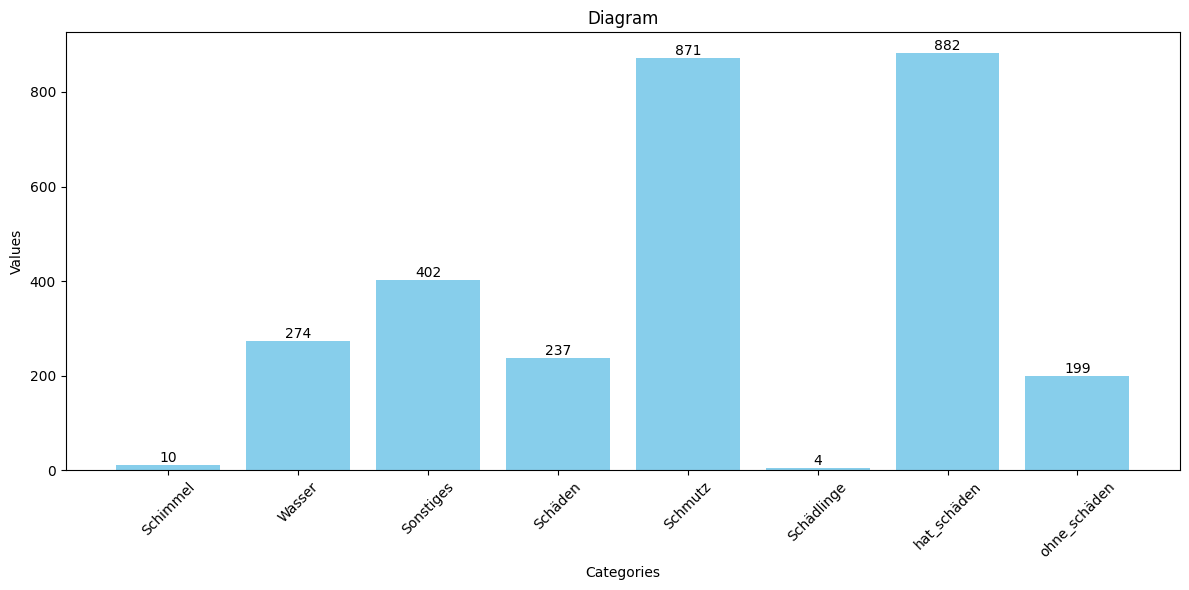

In [10]:
truthlist.update({"hat_schäden":hat_schäden[True], "ohne_schäden": hat_schäden[False]})

# Plot of the values

labels = list(truthlist.keys())
values = list(truthlist.values())


plt.figure(figsize=(12, 6))  
bars = plt.bar(labels, values, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Diagram')
plt.xticks(rotation=45)  
# Add value on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha="center")
plt.tight_layout() 
plt.show()

In [11]:
# took the label value from: Kategorie weiter aufteilen
# Displays the total amount of as damaged instances
label.notnull().sum().sum()


9008

## Extrahieren des image namens und droppen von image

In [12]:
image_namen_liste = []
data_preprocessed["image_name"] = None
for i, row in data_preprocessed.iterrows():
    data_preprocessed.loc[i, "image_name"] = row["image"].split("/")[-1]
    z = row["image"].split("/")[-1]
    image_namen_liste.append(f"{z}")
data_preprocessed = data_preprocessed.drop("image", axis=1)

## Koordinate in Listen zusammenfassen

In [13]:


label = pd.json_normalize(data_preprocessed["label"])

data_preprocessed["boxpoints"] = None
for x in range(label.shape[0]):
    info = {}
    # colums
    for y in range(label.shape[1]):
        
        temp = []
        if label[y][x] != None:
            temp.extend(label[y][x]["polygonlabels"])
            temp.append(label[y][x]["points"])
            info.update({y:temp})
    info = np.asarray(info)
    print(data_preprocessed["hat_schäden"][46])
    if data_preprocessed["hat_schäden"][x+1]:
        data_preprocessed.loc[x + 1, "boxpoints"] = info
    

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Extrahieren eines kleinen Datensets für erste Experimente

Das Ziel ist es ein möglichst ausgeglichenes Datenset zu erhalten

In [14]:

data_sample_temp = []
random_state = 42
sample_size = 7
for x in total:
    size = len(data_preprocessed.loc[data_preprocessed[x] == True].index)
    if size < sample_size:
        data_sample_temp.append(data_preprocessed.loc[data_preprocessed[x] == True].sample(n=size, random_state=random_state).index)
        print("Sample size for " + x + " is " + str(size) + " instead of the wanted sample size of " + str(sample_size) + ". Has not more entries then that.")
    else:
        data_sample_temp.append(data_preprocessed.loc[data_preprocessed[x] == True].sample(n=sample_size, random_state=random_state).index)

# Takes a sample from not damaged bookpictures
size = len(data_preprocessed.loc[data_preprocessed["hat_schäden"] == False].index)
if size < sample_size:
    data_sample_temp.append(data_preprocessed.loc[data_preprocessed["hat_schäden"] == False].sample(n=size, random_state=random_state).index)
    print("Sample size for \"hat_schäden\" is " + str(size) + " instead of the wanted sample size of " + str(sample_size) + ". Has not more entries then that.")
else:
    data_sample_temp.append(data_preprocessed.loc[data_preprocessed["hat_schäden"] == False].sample(n=sample_size, random_state=random_state).index)

data_sample = pd.DataFrame(data_sample_temp)
print(data_sample)
testrow = 3
valrow = 4
data_test = pd.DataFrame(data_sample[testrow]) # nur in dem kleinen fall verwendbar wenn die daten noch nicht gelöscht wurden. 
data_val = pd.DataFrame(data_sample[valrow])
data_train = data_sample.loc[:, data_sample.columns != testrow]

Sample size for Schädlinge is 4 instead of the wanted sample size of 7. Has not more entries then that.
     0    1    2    3       4      5       6
0  146   52   91   46   109.0   61.0   163.0
1  159  494  618  388   988.0  797.0   935.0
2  853  846  124  709   402.0  380.0  1052.0
3  477   48  825  494    21.0  613.0    35.0
4  489   93  624   94  1057.0  946.0   117.0
5  123  176   66  159     NaN    NaN     NaN
6  455   70  555  992   381.0  862.0   331.0


In [15]:
def into_list(data):
    flat = data.to_numpy().flatten()
    # list is optional, without it is a numpy array
    index_list = list(flat[~np.isnan(flat)].astype(int))
    return index_list


datalist_train = into_list(data_train)
datalist_val = into_list(data_val)
# datalist_test = into_list(data_test)


## change to COCO Datastructure
https://cocodataset.org/#format-data
https://github.com/Taeyoung96/Yolo-to-COCO-format-converter

## export data into seperate Datasets

In [16]:
def extractsublist(originaldata, datalist):
    dataset = originaldata.iloc[datalist]
    return dataset

def extract_nameending(data):
    """Input must have the column: image"""
    data["image_name"] = None
    for i, row in data.iterrows():
        data.loc[i, "image_name"] = row["image"].split("/")[-1]
    data = data.drop("image", axis=1)
    return data

def export(data, name):
    filename = f"{name}.json"
    data.to_json(filename)

dataexport_train = extractsublist(data, datalist_train)
dataexport_train = extract_nameending(dataexport_train)
dataexport_train.head()
# export(dataexport_train, "Trainingdata")

C:\Users\Michael\AppData\Local\Temp\ipykernel_9792\4154040355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["image_name"] = None


,choice,label,annotator,annotation_id,created_at,updated_at,lead_time,image_name
id,,,,,,,,
147,NaN,"[{'points': [[22.156270306818218, 24.152013730...",1,246,2023-12-04 14:02:56.554854+00:00,2023-12-04 14:02:56.554870+00:00,49.515,LB00001035.png
53,Manuell überprüfter Container,"[{'points': [[50.777369418324426, 55.228380434...",1,124,2023-09-26 08:58:36.491863+00:00,2023-09-26 08:58:36.491881+00:00,49.121,LB00000410.png
92,NaN,"[{'points': [[57.37723827714646, 70.4030129649...",1,200,2023-09-26 11:17:36.646951+00:00,2023-09-26 11:17:36.646969+00:00,73.292,LB00000503.png
110,NaN,"[{'points': [[19.97011915885095, 37.1039417518...",1,216,2023-12-04 12:13:01.159678+00:00,2023-12-04 12:13:01.159694+00:00,4129.937,LB00000586.png
62,NaN,"[{'points': [[31.09667939787316, 30.8655531796...",1,133,2023-09-26 09:08:48.512607+00:00,2023-09-26 09:08:48.512625+00:00,75.633,LB00000436.png


## Export from COCO json file

erstellen eines zweiten files aus dem die doppelten und nicht annotierten image daten gelöscht wurden.

In [17]:
import json
import datetime

path = "../../../old/BAA/coco_annotations.json"

newpath = "../../../old/BAA/Data/"
newfilename = "coco_annotations_cleaned.json"
completeNewPath = "../../../old/BAA/coco_annotations_cleaned.json"

In [18]:
# with open(path, "r") as f:
#     cocoOriginal = json.load(f)

def createSubsetStructure(originalData, description):
    subsetStructure = {
        "info": [{"year": int(datetime.date.today().year)},
                {"version": "1.0"},
                {"description": description},
                {"contributer": "Michael Infanger"},
                {"url": ""},
                {"date_created": str(datetime.datetime.now())}],
        "categories": originalData["categories"],
        "images": [],
        "annotations": []
    }
    return subsetStructure

def clearCOCO(cocoOriginal, image_namen_ls):
    imageIDlist = []
    notUsedImageNames = []
    descr = "gecleantes COCO Datenset, ohne doppelte Bilder, ohne nicht annotierten Bilder, nur daten die in dem Ursprungsexport dieses Projekts enthalten waren"
    cocoNew = createSubsetStructure(cocoOriginal, description=descr)
    minID = cocoOriginal["annotations"][0]["image_id"] # kleineste ID der annotierten Daten
    lastID = cocoOriginal["images"][-1]["id"]
    for n in range(minID, lastID + 1): #last ID included
        cocoOriginal["images"][n]["file_name"] = cocoOriginal["images"][n]["file_name"].split("/")[-1]
        if cocoOriginal["images"][n]["file_name"] in image_namen_ls:
            imageIDlist.append(cocoOriginal["images"][n]["id"])
            cocoNew["images"].append(cocoOriginal["images"][n])
        elif n == minID: # need this because the first three images begin with a %, this was used to format strings, and it is still working apparently. Because of it, this images werent catched with the first if statement...
            imageIDlist.append(cocoOriginal["images"][n]["id"])
            cocoNew["images"].append(cocoOriginal["images"][n])
        elif n == minID + 1:
            imageIDlist.append(cocoOriginal["images"][n]["id"])
            cocoNew["images"].append(cocoOriginal["images"][n])
        elif n == minID + 2:
            imageIDlist.append(cocoOriginal["images"][n]["id"])
            cocoNew["images"].append(cocoOriginal["images"][n])
        else: 
            notUsedImageNames.append(cocoOriginal["images"][n]["file_name"])
    for i in range(len(cocoOriginal["annotations"])):
        if cocoOriginal["annotations"][i]["image_id"] in imageIDlist:
            cocoNew["annotations"].append(cocoOriginal["annotations"][i])
    return cocoNew

def writeJson(jsonObject, filename):
    if filename.split(".")[-1] != "json":
        filename = f"{filename}.json"
    with open(filename, "w") as g:
        g.write(jsonObject)
        
# Uncomment if a new dataset needs to be loaded and cleared (thogether with the load statement)
# cocoCleared = clearCOCO(cocoOriginal=cocoOriginal, image_namen_ls=image_namen_liste)
# coco_cleared = json.dumps(cocoCleared, indent=4)
# writeJson(coco_cleared, completeNewPath)

In [19]:
data_preprocessed["image_name"].loc[1]

'%25B00001340.png'

In [20]:



with open(completeNewPath, "r") as f:
    cocox = json.load(f)

# Say descriptions
description_train = "trainingset_small"
description_val = "validierungsset_small"
description_test = "testset_small"

# to use the original split from the YOLO format in the newer export of COCO that has high ID's
def adapt_IDList(cocodata, subsetIDList):
    namelist = []
    ID_cleaned_list = []
    for n in subsetIDList:
        namelist.append(data_preprocessed["image_name"].loc[n])
    for i in cocodata["images"]:
        if i["file_name"] in namelist:
            ID_cleaned_list.append(i["id"])
    return ID_cleaned_list

def createSubsetImages(subset, cocodata, subsetIDList):
    # change file_name for the actual name without the whole path
    for n in range(len(cocodata["images"])):
        # not needed with a cleaned dataset
        # cocodata["images"][n]["file_name"] = cocodata["images"][n]["file_name"].split("/")[-1]
        if cocodata["images"][n]["id"] in subsetIDList:
            subset["images"].append(cocodata["images"][n])

def createSubsetAnnotations(subset, cocodata, subsetIDList):
    for n in range(len(cocodata["annotations"])):
        # not needed with a cleaned IDlist
        # cocodata["annotations"][n]["image_id"] -= 20000
        if cocodata["annotations"][n]["image_id"] in subsetIDList:
            subset["annotations"].append(cocodata["annotations"][n])

def createCOCOSubset(cocodata, subsetIDList, description):
    cocosub = createSubsetStructure(cocodata, description=description)
    createSubsetImages(cocosub, cocodata, subsetIDList)
    createSubsetAnnotations(cocosub, cocodata, subsetIDList)
    return cocosub

# clean subsetIDLists in order to be used with the coco dataset that uses way too hight id numbers
d_train = adapt_IDList(cocox, datalist_train)
d_val = adapt_IDList(cocox, datalist_val)
# d_test = adapt_IDList(cocox, datalist_test)


trainset = createCOCOSubset(cocox, d_train, description=description_train)
valset = createCOCOSubset(cocox, d_val, description=description_val)
# testset = createCOCOSubset(cocox, d_test, description=description_test)

json_train = json.dumps(trainset, indent=4)
json_val = json.dumps(valset, indent=4)
# json_test = json.dumps(testset, indent=4)

target_directory = "../../../old/BAA/Annotierte_Bilder/2024-02-21-Schadenserkennung-Annotationen/"


# export data to separate files
trainpath = newpath + "train/"
valpath = newpath + "val/"
# testpath = newpath + "test/"


writeJson(json_train, trainpath + "coco_train.json")
writeJson(json_val, valpath + "coco_val.json")
# writeJson(json_test, testpath + "coco_test.json")


image_folder = target_directory + "images/"




In [21]:
def copyImages(image_list, target_dict):
    images = glob.glob(os.path.join(image_folder, "*.png"))
    for i in images:
        basename = os.path.basename(i)
        if basename in image_list:
            shutil.copy(i, target_dict)

def moveImages(image_list, target_dict):
    images = glob.glob(os.path.join(image_folder, "*.png"))
    for i in images:
        basename = os.path.basename(i)
        if basename in image_list:
            shutil.move(i, target_dict)

def delInfos(dataset, dataset_to_delete_stuff):
    # should only be used once on the data for the testdata
    # Iterate through dataset and delete any image and annotation that has the id of the image list
    return_data = copy.deepcopy(dataset_to_delete_stuff)
    img_id = []
    run_idx = []
    anno_idx = []
    for n in range(len(dataset["images"])):
        for i in range(len(dataset_to_delete_stuff["images"])):
            if dataset["images"][n]["id"] == dataset_to_delete_stuff["images"][i]["id"]:
                img_id.append(dataset_to_delete_stuff["images"][i]["id"])
                run_idx.append(i)
        for y in range(len(dataset_to_delete_stuff["annotations"])):
            if dataset_to_delete_stuff["annotations"][y]["image_id"] in img_id:
                anno_idx.append(y)
    
    delcount = 0

    for z in run_idx:
        del return_data["images"][z-delcount]
        delcount += 1
    
    delcount = 0

    for x in anno_idx:
        del return_data["annotations"][x-delcount]
        delcount += 1

    return return_data


def getImageNames(cocodata):
    nameList = []
    for n in cocodata["images"]:
        nameList.append(n["file_name"])
    return nameList

train_names = getImageNames(trainset)
val_names = getImageNames(valset)
# test_names = getImageNames(testset)

# copyImages(train_names, trainpath)
# copyImages(val_names, valpath)
# moveImages(test_names, testpath)

# data_deleted = delInfos(testset, cocox)
# d_delete = json.dumps(data_deleted, indent=4)
# writeJson(d_delete, completeNewPath)


## grosses Datenset erstellen

In [22]:
len(cocox["images"])

{'info': [{'year': 2024},
  {'version': '1.0'},
  {'description': 'gecleantes COCO Datenset, ohne doppelte Bilder, ohne nicht annotierten Bilder, nur daten die in dem Ursprungsexport dieses Projekts enthalten waren'},
  {'contributer': 'Michael Infanger'},
  {'url': ''},
  {'date_created': '2024-04-25 16:42:28.419602'}],
 'categories': [{'id': 0, 'name': 'Bildartefakte'},
  {'id': 1, 'name': 'Manuell überprüfter Container'},
  {'id': 2, 'name': 'Schimmel'},
  {'id': 3, 'name': 'Schmutz'},
  {'id': 4, 'name': 'Schäden'},
  {'id': 5, 'name': 'Schädlinge'},
  {'id': 6, 'name': 'Sonstiges'},
  {'id': 7, 'name': 'Starke Überbeleuchtung oder Unterbeleuchtung'},
  {'id': 8, 'name': 'Unerwartetes Layout'},
  {'id': 9, 'name': 'Wasser'}],
 'images': [{'width': 1944,
   'height': 1200,
   'id': 20439,
   'file_name': '%B00001340.png'},
  {'width': 1944, 'height': 1200, 'id': 20440, 'file_name': '%B00038803.png'},
  {'width': 1944, 'height': 1200, 'id': 20441, 'file_name': '%B00078304.png'},
  {'

Zeile 216 hat die meisten schadenseinträge, gesamt 37

## Fazit

1. Es ist im grossen und ganzen ein guter Datensatz
    - musste keine rows löschen
2. Die verlinkung der einzelnen Bilder sind vollständig
3. Die Datenmenge ist sehr dürftig für einen Ai algorithmus
    - Data Augmentation als gegenmassnahme
4. Die verteilung der Daten ist sehr ungleich. Bsp. es hat 871 Bilder mit Schmutzschäden aber nur vier mit Schädlingen
    - Es braucht mehr Daten, es ist eine überlegung wert die fälle mit den wenigsten vorkommnissen nicht zu gebrauchen oder erst in einem späteren stadium, alternativ könnten im allgemeinen wenige daten verwendet werden um die unterschiede in den mengen zu verkleinern.